# Feature Similarity Between Asian Elephants

<h3><u>Using Contrastive Loss</u></h3>


## Imports

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from torchvision import models

 
%matplotlib inline


## Helper functions

In [2]:
## visualization helper
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    image = np.transpose(npimg,(1,2,0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.show() 
        
def visualize_loss(epochs, loss):
    plt.plot(range(epochs),loss)
    plt.show()
    
    
class RunningAverage(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

## Configuration

In [3]:
class Config():
    train_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/train"
    val_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/val/"
    test_dir = "/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/test/New_test_Photos"
    batch_size = 128
    nepochs = 100
    learning_rate = 0.001
    num_classes = 14
    test_freq = 20
        
        
print(Config.train_dir)      

/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/train


## Dataset and Dataloaders

In [4]:
## Dataset - build pairs of images - 0, same class, 1 for opposite pair
class AsianElephantSiemeseDataset(Dataset):
    def __init__(self,imagefolder_dataset, transform = None):
        self.imagefolder_dataset = imagefolder_dataset
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imagefolder_dataset.imgs)
        
        
        
        ## 50% same class and 50% opposite class
        same_class = random.randint(0,1)
        if same_class:
            ## loop until we find image of the same class
            while True:
                ##
                img1_tuple = random.choice(self.imagefolder_dataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    ## found image so, break
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imagefolder_dataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
                    
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        label0 = img0_tuple[1]
        label1 = img1_tuple[1]
        
        ## convert to PIL image
        img0 = img0
        img1 = img1
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), (label0,label1)
    
    
    def __len__(self):
        return len(self.imagefolder_dataset.imgs)
    

##### Image Folders

Train - All images
<br/>
Val - Superclean images
<br/>
Test - New Test Photos

In [5]:
## Train Image Folder, Test Image Folder

train_image_folder = dset.ImageFolder(root = Config.train_dir)

classes = train_image_folder.classes

In [6]:
train_image_folder.imgs[0]

('/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/baseline-data/train/Beco/Beco_IMG_6565.JPG',
 0)

In [7]:
## Dataloaders
normalize = torchvision.transforms.Normalize(
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
        'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
        ]),
     
      'test': torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
        ])

    }

train_dataset = AsianElephantSiemeseDataset(train_image_folder,data_transforms["train"])


In [8]:
print(f" Number of train images:{len(train_dataset)}")

 Number of train images:19290


In [9]:
train_loader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=4,pin_memory=True,
                        batch_size=Config.batch_size)




In [10]:
val_image_folder = dset.ImageFolder(root = Config.val_dir, transform=data_transforms["test"])
val_loader = torch.utils.data.DataLoader(val_image_folder,batch_size=len(val_image_folder), sampler=None,num_workers=4,pin_memory=True)
val_origin, val_y_origin = next(iter(val_loader))

## Visualize Some Examples

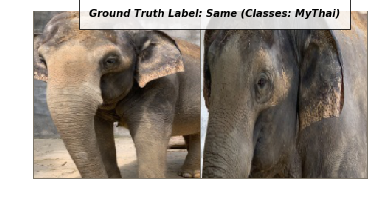

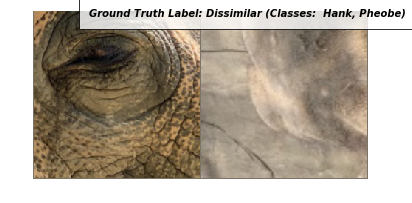

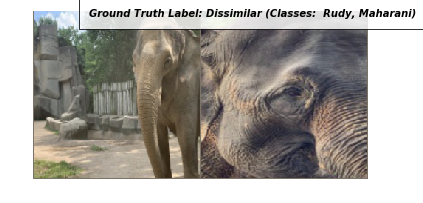

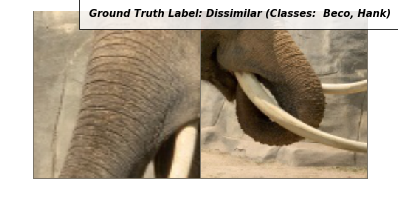

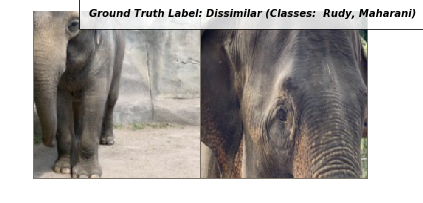

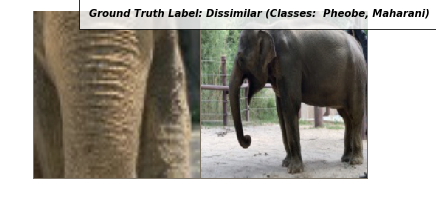

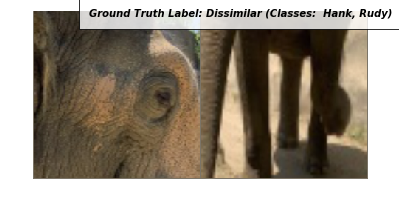

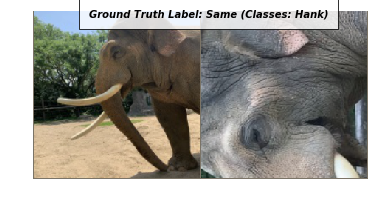

In [12]:
batch_size = 4
vis_dataloader = DataLoader(train_dataset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=1)
dataiter = iter(vis_dataloader)


nrows = 4
ncols = 3

for batch_idx in range(8):
    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1]),0)
    title = "Ground Truth Label: " + ",  ".join([("Same" if i[0]==0.0 else "Dissimilar") for i in example_batch[2].numpy()])
    if example_batch[2][0]==0.0:
        title+= " (Classes: "+ classes[example_batch[3][0]] +")"
    else:
        title+=" (Classes: "+ f" {classes[example_batch[3][0]]}, {classes[example_batch[3][1]]}" + ")"
    imshow(torchvision.utils.make_grid(concatenated),title, False)
            

## Model

In [13]:
import copy
import math
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=14):
        
        self.inplanes = 64
        
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        return x


In [14]:
class AsianElephantSiemeseNetwork(nn.Module):
    def __init__(self,resnet_conv,convout_dimension):
        super(AsianElephantSiemeseNetwork,self).__init__()
        ## check with Shujon
        self.resnet_conv = resnet_conv
        self.convout_dimension = convout_dimension
        
    def forward_once(self, x):
        x = self.resnet_conv(x)
        return x.view(-1,self.convout_dimension)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


## Contrastive Loss

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive Loss
    """
    def __init__(self, margin = 2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin = margin
        
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
    


## Evaluation Metrics

Evaluation Metric is different from traditional classifier network

Reference: https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352

In [16]:
from sklearn.metrics import roc_curve,roc_auc_score

def compute_prob(network, X, Y):
    """
      Input: network - model
      X: input tensor - containing images to evaluate"
      Y: tensor containing true class
    """
    
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros(nbevaluation)
    y = np.zeros(nbevaluation)
    
    ## compute all embeddings
    embeddings = model.module.forward_once(X.cuda()).detach().cpu()
    embeddings = embeddings.numpy()
    size_embedding = embeddings.shape[1]

    ## for each image in the dataset
    k = 0
    for i in range(m):
        ## Against all others images
        for j in range(i+1, m):
            probs[k] = compute_dist(embeddings[i,:],embeddings[j,:])
            if Y[i] == Y[j]:
                y[k] = 0
                #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
            else:
                y[k] = 1
                #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
            k+=1
    return probs, y

## Compute Pairwise Euclidean Distance
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(model,img_folder):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    nb_classes = Config.num_classes
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,3,224,224))
    occurrences = lambda s, lst: (i for i,e in enumerate(lst) if e == s)
    transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
           
        ])
    
    #generates embeddings for reference images
    targets = [i[1] for i in val_image_folder.imgs]

    for i in range(nb_classes):
        target_idx = list(occurrences(0,targets))
        for index in target_idx:
            img_path = img_folder.imgs[index][0]
            img = Image.open(img_path)
            img = img.convert("RGB")
          
            ref_images[i,:,:,:] = transform(img)
        
            
    ref_embeddings = model.module.forward_once(torch.from_numpy(ref_images).float().cuda()).detach().cpu()
    ref_embeddings = ref_embeddings.numpy()
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res


def draw_interdist(model, epoch,img_folder):
    data = []
    interdist = compute_interdist(model,img_folder)
    
    nb_classes = len(classes)
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(epoch))
    ax.set_ylim([0,3])

    plt.xlabel('Classes')
    plt.ylabel('Distance')
    
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

        
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()


## Training

In [17]:
model = ResNet(BasicBlock, [3, 4, 6, 3])

model = AsianElephantSiemeseNetwork(model, 512)
if torch.cuda.is_available:
    if torch.cuda.device_count()>1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model = model.cuda()
    
    

Let's use 4 GPUs!


In [18]:
criterion = ContrastiveLoss()
if torch.cuda.device_count()>1:
    optimizer = optim.Adam(model.module.parameters(),lr = Config.learning_rate)
else:
    optimizer = optim.Adam(model.parameters(),lr = Config.learning_rate)

In [19]:
def train(epoch):
    model.train()
    losses = RunningAverage("train loss per batch")
    
    for i, data in enumerate(train_loader):
        img0, img1 , label, actual_labels = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        ## Optimizer - reset gradients
        optimizer.zero_grad()
        
        ## forward pass, extract features
        features1,features2 = model(img0,img1)
        
        ## compute contrastive loss
        loss_contrastive = criterion(features1,features2,label)
        
        ## Backward pass and update
        losses.update(loss_contrastive.item(), label.size(0))
        loss_contrastive.backward()
        
        ## update the weights
        optimizer.step()
        
    return losses.avg




Starting training process!
----------------------------------------------------------------------------------------------------
0 Train Loss: 1.7602

 ------------- 

[0] Time for 0 iterations: 2.8 mins, Train Loss: 1.760227676720864


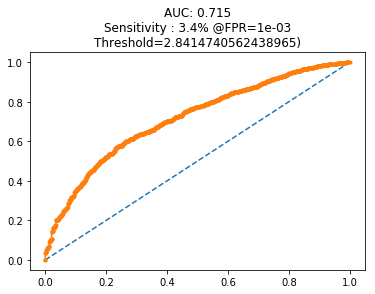

1 Train Loss: 0.9051
2 Train Loss: 0.8785
3 Train Loss: 0.8401
4 Train Loss: 0.8169
5 Train Loss: 0.7785

 ------------- 

[5] Time for 5 iterations: 16.0 mins, Train Loss: 0.7785410757260103


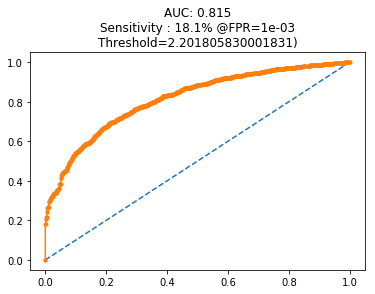

6 Train Loss: 0.7578
7 Train Loss: 0.7439
8 Train Loss: 0.7190
9 Train Loss: 0.6913
10 Train Loss: 0.6673

 ------------- 

[10] Time for 10 iterations: 29.3 mins, Train Loss: 0.667257463085398


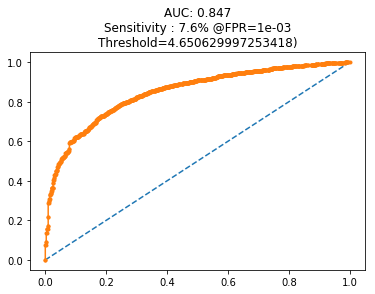

11 Train Loss: 0.6634
12 Train Loss: 0.6310
13 Train Loss: 0.6013
14 Train Loss: 0.5915
15 Train Loss: 0.5684

 ------------- 

[15] Time for 15 iterations: 42.5 mins, Train Loss: 0.5684295367181085


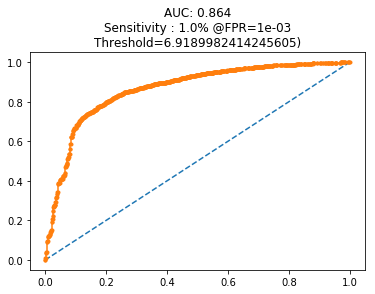

16 Train Loss: 0.5763
17 Train Loss: 0.5488
18 Train Loss: 0.5367
19 Train Loss: 0.5260
20 Train Loss: 0.5178

 ------------- 

[20] Time for 20 iterations: 55.8 mins, Train Loss: 0.517847849434061


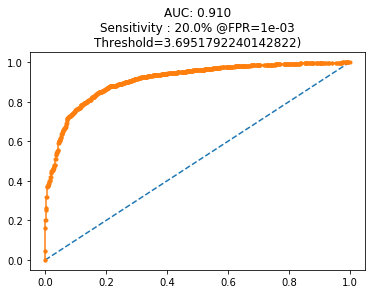

21 Train Loss: 0.5071
22 Train Loss: 0.4828
23 Train Loss: 0.4860
24 Train Loss: 0.4788
25 Train Loss: 0.4565

 ------------- 

[25] Time for 25 iterations: 69.0 mins, Train Loss: 0.4565470320904051


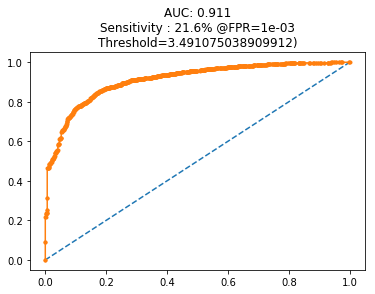

26 Train Loss: 0.4490
27 Train Loss: 0.4352
28 Train Loss: 0.4210
29 Train Loss: 0.4198
30 Train Loss: 0.3972

 ------------- 

[30] Time for 30 iterations: 82.2 mins, Train Loss: 0.3972176518231368


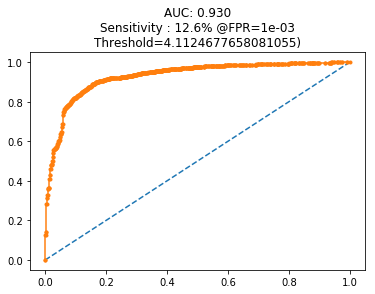

31 Train Loss: 0.3969
32 Train Loss: 0.3846
33 Train Loss: 0.3822
34 Train Loss: 0.3559
35 Train Loss: 0.3576

 ------------- 

[35] Time for 35 iterations: 95.5 mins, Train Loss: 0.35757940789156467


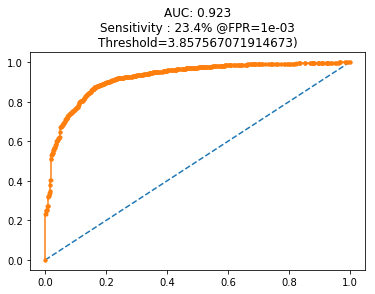

36 Train Loss: 0.3592
37 Train Loss: 0.3444
38 Train Loss: 0.3356
39 Train Loss: 0.3164
40 Train Loss: 0.3126

 ------------- 

[40] Time for 40 iterations: 108.7 mins, Train Loss: 0.3125573901483715


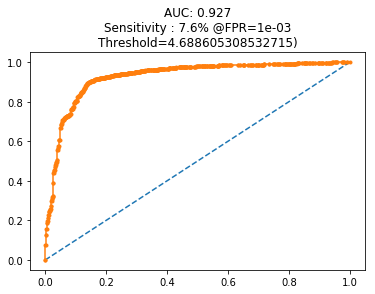

41 Train Loss: 0.3127


RuntimeError: CuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [20]:
import time
train_losses = []
val_losses = []
val_accuracy = []
counter = []
iteration_number= 0
auc_epochs  = []
threshold_list = []

best_auc = -1
best_threshold = 0

print("Starting training process!")
print("-"*100)
t_start = time.time()

for epoch in range(Config.nepochs):
    train_loss = train(epoch)
    print('{} Train Loss: {:.4f}'.format(epoch,train_loss))
    train_losses.append(train_loss)
    if epoch % 5 == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(epoch, (time.time()-t_start)/60.0,train_loss,epoch))
        probs,yprob = compute_prob(model, val_origin[:,:,:,:],val_y_origin[:])
        fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        if auc>best_auc:
            best_auc = auc
            best_threshold = thresholds
            ## Save model
            torch.save(model.state_dict(), './best_siamese_contrastive_loss.pth')
        draw_roc(fpr,tpr, thresholds)
        
        ## Save Metrics
        auc_epochs.append(auc)
        threshold_list.append(thresholds)

Text(0.5, 1.0, 'Train Loss over epochs')

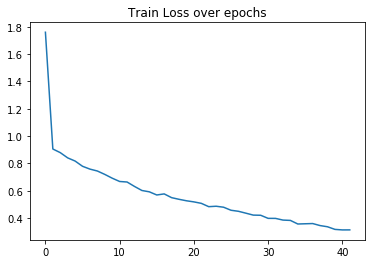

In [25]:

plt.plot(train_losses)
plt.title("Train Loss over epochs")

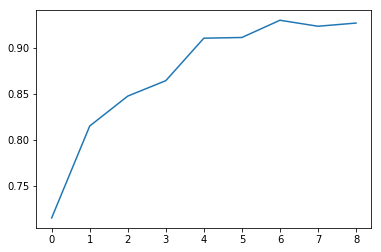

In [26]:
plt.plot(auc_epochs)

In [20]:
checkpoint = torch.load("best_siamese_contrastive_loss.pth")
model.load_state_dict(checkpoint)
print("=> loaded checkpoint ")

=> loaded checkpoint 


## Test 

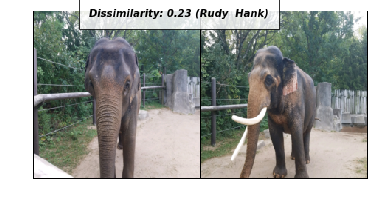

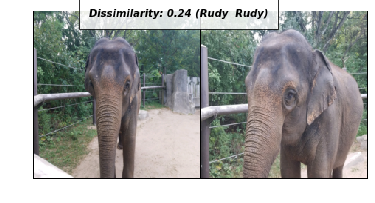

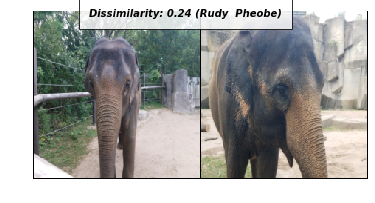

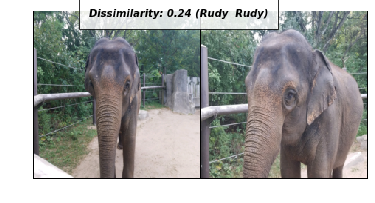

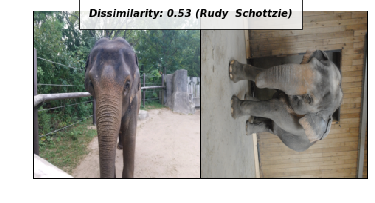

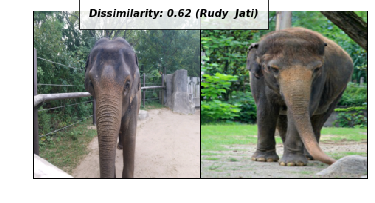

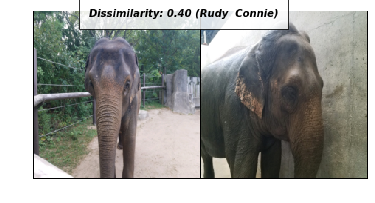

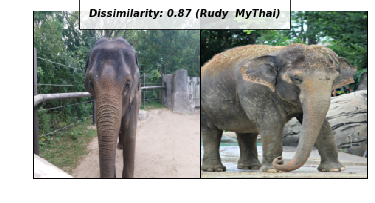

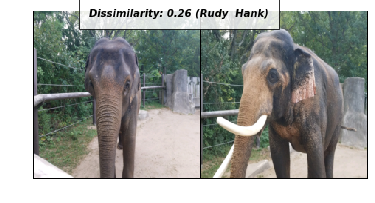

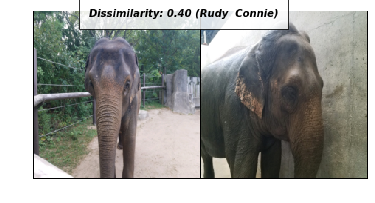

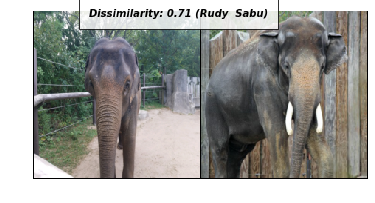

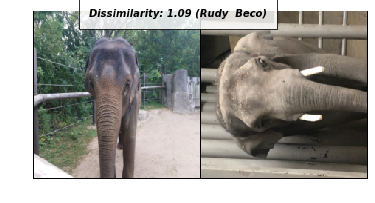

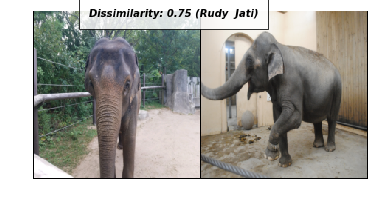

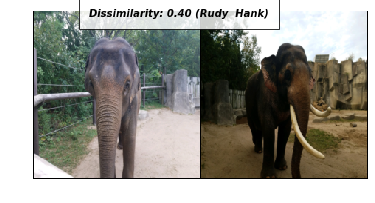

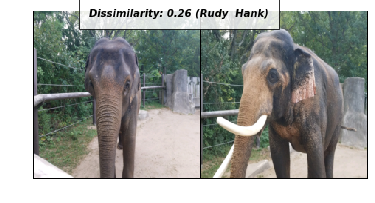

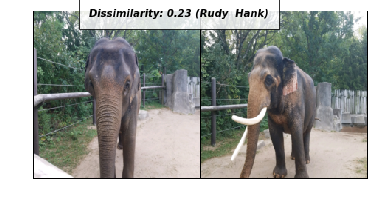

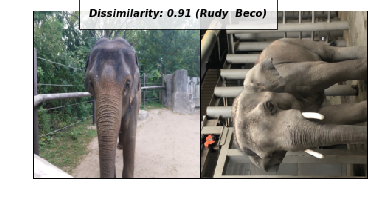

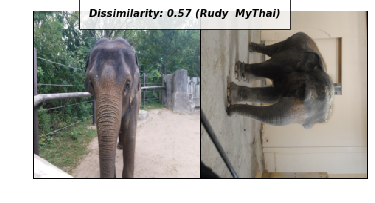

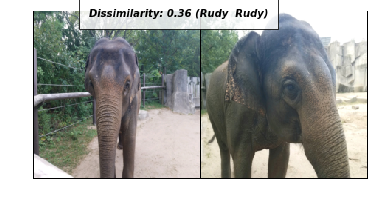

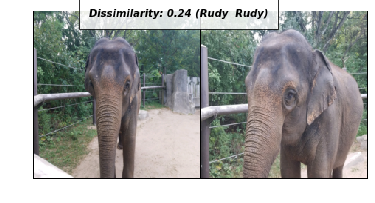

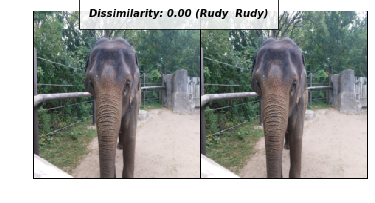

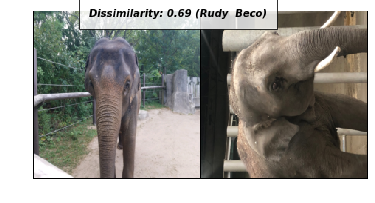

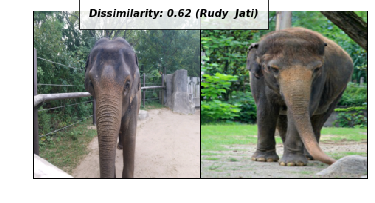

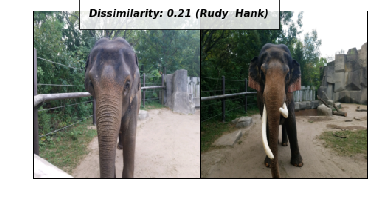

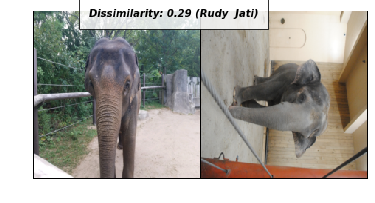

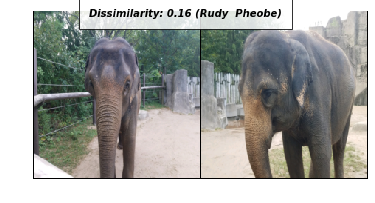

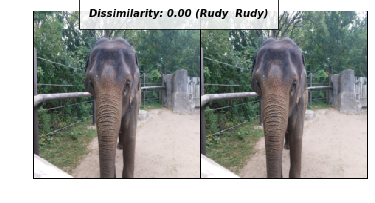

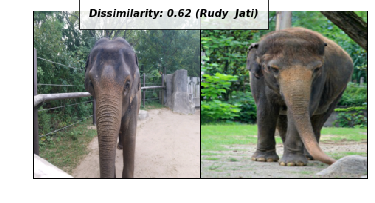

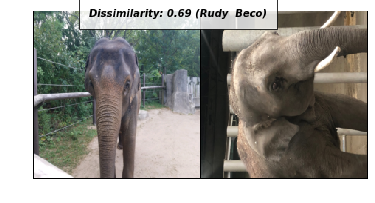

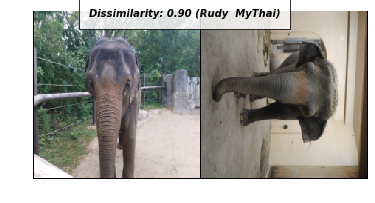

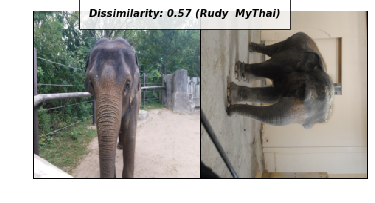

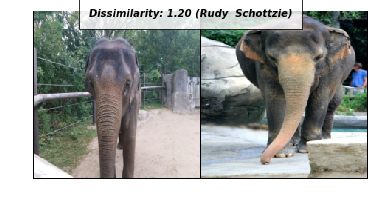

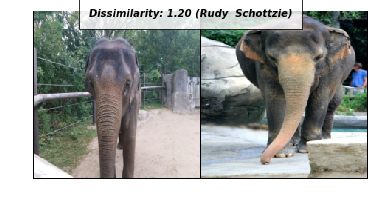

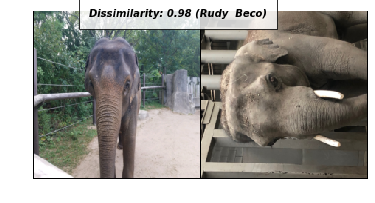

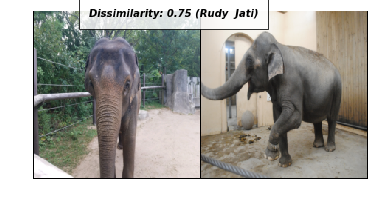

In [27]:
def image_show(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2, 0)))
    plt.show()    
    
folder_dataset_test = dset.ImageFolder(root=Config.test_dir)
siamese_dataset = AsianElephantSiemeseDataset(folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(siamese_dataset,num_workers=1,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)
x0,_,_, actual_label0 = next(dataiter)

for i in range(35):
    _,x1,label2, actual_labels = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = model(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    image_show(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item())+ f" ({classes[actual_label0[0]]}  {classes[actual_labels[1]]})")

True